# Chapter 12

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import struct
import sys

plt.style.use({'figure.facecolor': 'white'})

## 12.2

In [5]:
def load_mnist(path, kind="train"):
    labels_path = os.path.join(path, "%s-labels-idx1-ubyte" % kind)
    images_path = os.path.join(path, "%s-images-idx3-ubyte" % kind)

    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, "rb") as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels

Rows:  60000, columns:  784
Rows:  10000, columns:  784


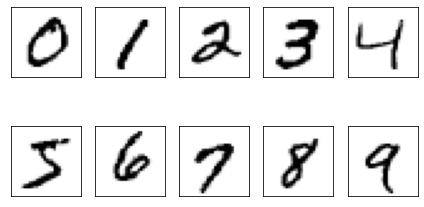

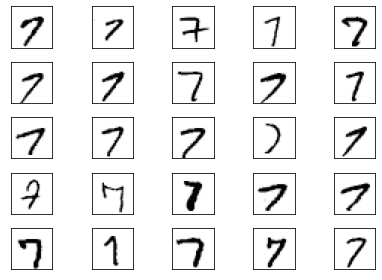

In [9]:
X_train, y_train = load_mnist("mnist\\", kind="train")
print(f"Rows: {X_train.shape[0]: d}, columns: {X_train.shape[1]: d}")
X_test, y_test = load_mnist("mnist\\", kind="t10k")
print(f"Rows: {X_test.shape[0]: d}, columns: {X_test.shape[1]: d}")

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [10]:
np.savez_compressed("mnist_scaled.npz", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [11]:
mnist = np.load("mnist_scaled.npz")

In [12]:
print(mnist.files)
X_train = mnist["X_train"]
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

['X_train', 'y_train', 'X_test', 'y_test']


In [ ]:
class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2=0, epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    # n_classes: ラベルの種類数？
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    
